In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import shutil
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve

d:\Achademy projects\show\SDA project\SDA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Administrator\AppData\Roamin

True

In [3]:
dataset_path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

relative_path = os.path.join(".", "data", "Twitter")
shutil.move(dataset_path, relative_path)

train_path = os.path.join(relative_path, "twitter_training.csv")
test_path = os.path.join(relative_path, "twitter_validation.csv")

100%|██████████| 1.99M/1.99M [00:01<00:00, 1.48MB/s]

Extracting files...


In [4]:
df_train = pd.read_csv(train_path, names = ['ID','Company', 'Sentiment','tweet'])
df_test = pd.read_csv(test_path, names = ['ID','Company', 'Sentiment','tweet'])

In [5]:
print(df_train.shape)
print(df_test.shape)

(74682, 4)
(1000, 4)


In [6]:
df_train['tweet'].iloc[6]

"So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg"

In [7]:
df_train.describe(include='object')

,Company,Sentiment,tweet
count,74682,74682,73996
unique,32,4,69491
top,Microsoft,Negative,
freq,2400,22542,172


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Company    74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
df_train['Sentiment'].value_counts()

Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

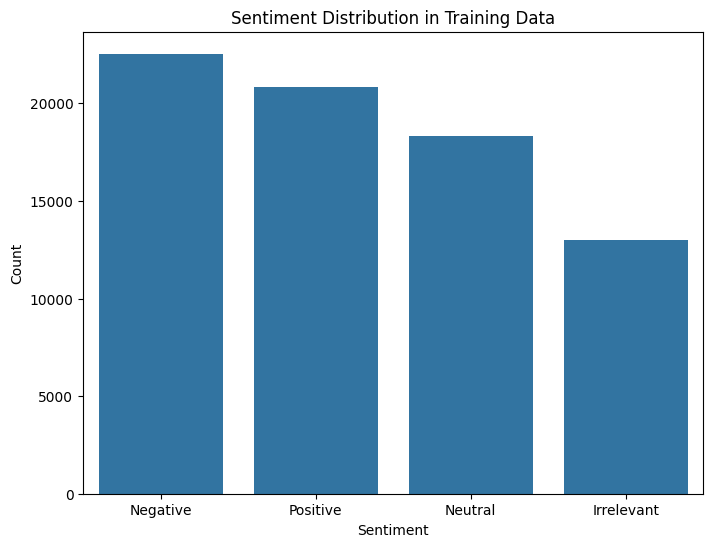

In [10]:
# 1. Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_train, order=df_train['Sentiment'].value_counts().index)
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

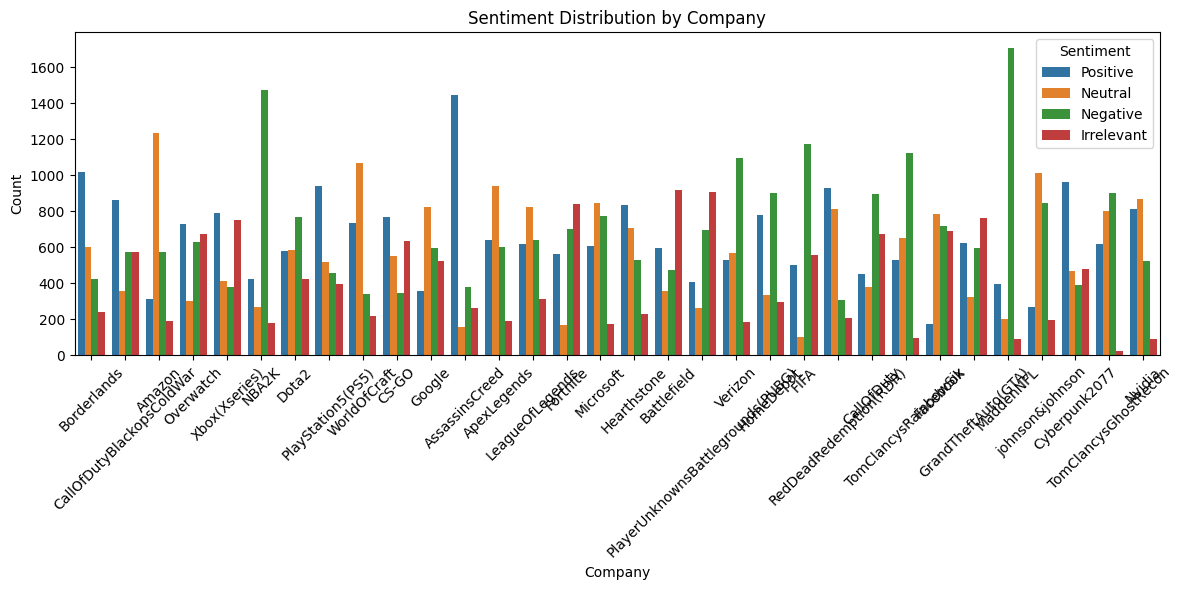

In [11]:
# 2. Company-wise Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Company', hue='Sentiment', data=df_train)
plt.title('Sentiment Distribution by Company')
plt.xlabel('Company')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

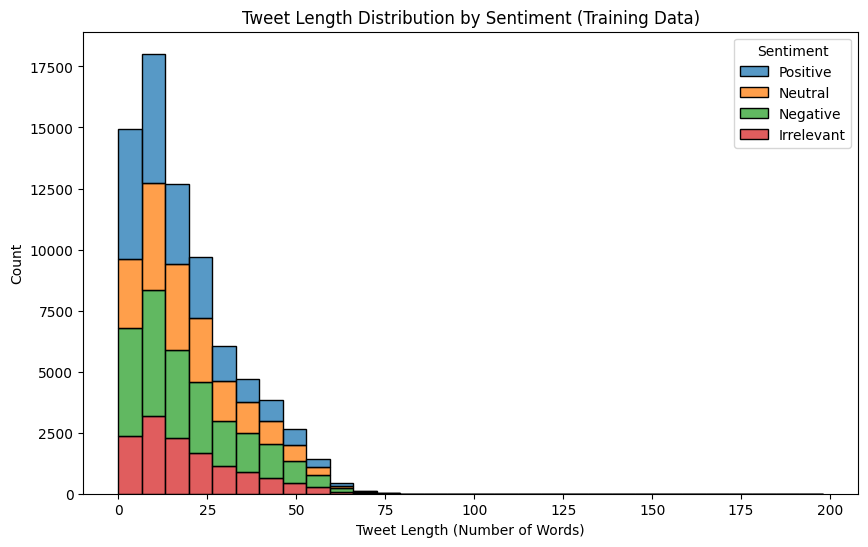

In [12]:
# 3. Tweet Length Analysis
df_train['tweet_length'] = df_train['tweet'].apply(lambda x: len(str(x).split()))
df_test['tweet_length'] = df_test['tweet'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='tweet_length', hue='Sentiment', multiple='stack', bins=30)
plt.title('Tweet Length Distribution by Sentiment (Training Data)')
plt.xlabel('Tweet Length (Number of Words)')
plt.ylabel('Count')
plt.show()

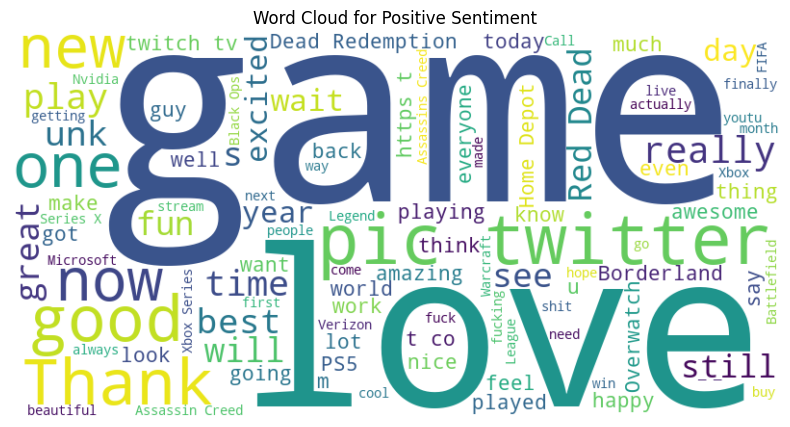

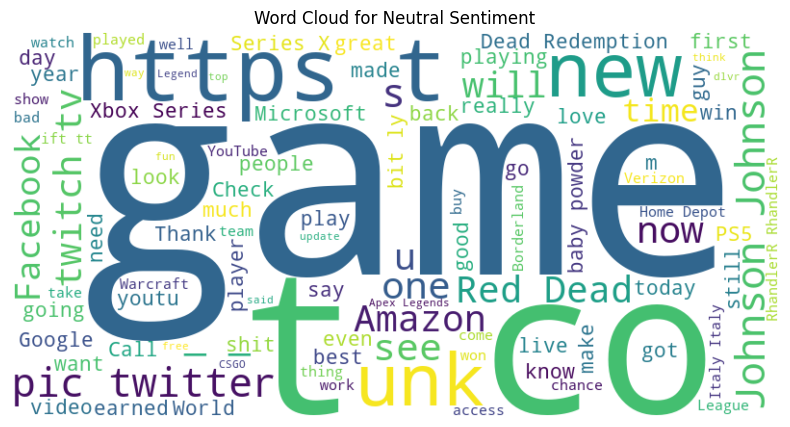

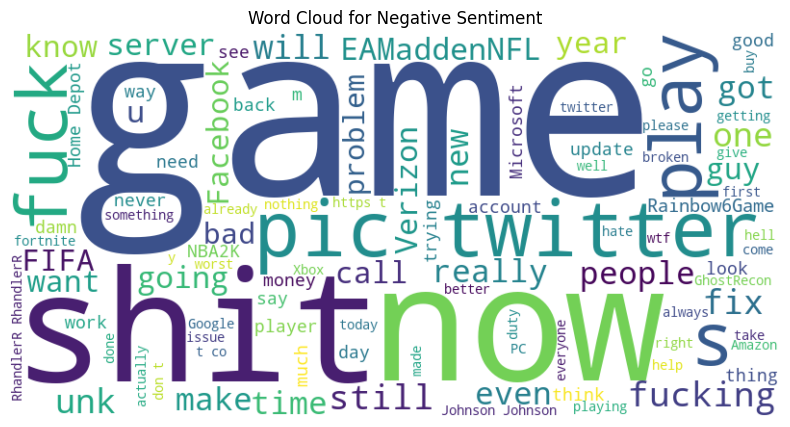

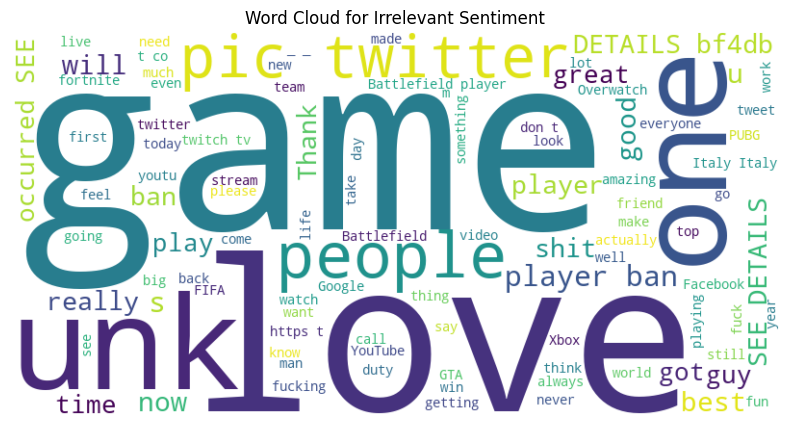

In [13]:
# 4. Word Cloud for Each Sentiment
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Combine tweets by sentiment for word clouds
sentiments = df_train['Sentiment'].unique()
for sentiment in sentiments:
    tweets = ' '.join(df_train[df_train['Sentiment'] == sentiment]['tweet'].astype(str))
    generate_wordcloud(tweets, f'Word Cloud for {sentiment} Sentiment')

In [14]:
print('# Null values in training data: ', df_train.isnull().sum())
print('\n# Null values in testing data: ',df_test.isnull().sum())

# Null values in training data:  ID                0
Company           0
Sentiment         0
tweet           686
tweet_length      0
dtype: int64

# Null values in testing data:  ID              0
Company         0
Sentiment       0
tweet           0
tweet_length    0
dtype: int64


In [15]:
df_train[df_train['tweet'].isnull()]['Sentiment'].value_counts()

Sentiment
Neutral       210
Negative      184
Positive      177
Irrelevant    115
Name: count, dtype: int64

In [16]:
df_train.dropna(inplace=True)

In [17]:
df_train.drop_duplicates(inplace=True)

In [18]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Dictionary for common Twitter slang and abbreviations
slang_dict = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing",
    "L8": "Late",
    "SMH": "Shaking My Head",
    "YOLO": "You Only Live Once",
    "TLDR": "Too Long; Didn't Read",
    "FOMO": "Fear Of Missing Out",
    "IDK": "I Don't Know",
    "BFFL": "Best Friends For Life",
    "TMI": "Too Much Information",
    "DM": "Direct Message",
    "STFU": "Shut The F... Up",
    "WTH": "What The Heck",
    "LMAOROTF": "Laughing My A... Off Rolling On The Floor",
    "PPL": "People",
    "SFLR": "Sorry For Late Reply",
    "G2G": "Got To Go",
    "S2R": "Send To Receive"
}


# Regex pattern for emojis
emoji_pattern = (
    "[\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"   # Miscellaneous Symbols and Pictographs
    "\U0001F680-\U0001F6FF"   # Transport and Map Symbols
    "\U0001F700-\U0001F77F"   # Alchemical Symbols
    "\U0001F780-\U0001F7FF"   # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"   # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"   # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"   # Chess Symbols
    "\U0001FA70-\U0001FAFF"   # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"   # Dingbats
    "\U000024C2-\U0001F251"   # Enclosed characters
    "]+"
)

def get_wordnet_pos(treebank_tag):
    """Map NLTK POS tags to WordNet POS tags for lemmatization."""
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun

def clean_tweet(text):
    """
    Clean and preprocess tweet text for classification.
    Handles links, hashtags, mentions, slang, emoticons, HTML, XML tags, and emojis.
    """
    if not isinstance(text, str):
        return []

    # Remove HTML and XML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (#hashtag)
    text = re.sub(r'#\w+', '', text)

    # Remove emojis
    text = re.sub(emoji_pattern, '', text, flags=re.UNICODE)

    # Remove special characters and numbers, keep letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Replace slang and abbreviations
    tokens = [slang_dict.get(token, token) for token in tokens]

    # Flatten multi-word slang (e.g., 'never mind' -> ['never', 'mind'])
    flattened_tokens = []
    for token in tokens:
        if ' ' in token:
            flattened_tokens.extend(token.split())
        else:
            flattened_tokens.append(token)

    # POS tagging
    pos_tags = pos_tag(flattened_tokens)

    # Remove stopwords and lemmatize with POS
    cleaned_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos_tag))
        for word, pos_tag in pos_tags
        if word not in stop_words
    ]

    return cleaned_tokens

In [19]:
df_train['pre_tweet'] = df_train['tweet'].apply(clean_tweet)
df_train

,ID,Company,Sentiment,tweet,tweet_length,pre_tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,11,"[im, get, borderland, murder]"
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,12,"[come, border, kill]"
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,10,"[im, get, borderland, kill]"
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,10,"[im, come, borderland, murder]"
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,12,"[im, get, borderland, murder]"
...,...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,26,"[realize, window, partition, mac, like, year, ..."
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,23,"[realize, mac, window, partition, year, behind..."
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,25,"[realize, window, partition, mac, year, behind..."
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,32,"[realize, window, partition, mac, like, year, ..."


In [20]:
df_test['pre_tweet'] = df_test['tweet'].apply(clean_tweet)
df_test['pre_tweet']

0      [mention, facebook, struggle, motivation, go, ...
1      [bbc, news, amazon, bos, jeff, bezos, reject, ...
2              [pay, word, function, poorly, chromebook]
3      [csgo, matchmaking, full, closet, hack, truly,...
4      [president, slap, american, face, really, comm...
                             ...                        
995    [toronto, art, culture, capital, canada, wonde...
996    [actually, good, move, tot, bring, viewer, one...
997    [today, suck, time, drink, wine, n, play, bord...
998        [buy, fraction, microsoft, today, small, win]
999    [johnson, johnson, stop, sell, talc, baby, pow...
Name: pre_tweet, Length: 1000, dtype: object

In [21]:
df_train['pre_tweet'] = df_train['pre_tweet'].apply(lambda x: ' '.join(x))
df_train

,ID,Company,Sentiment,tweet,tweet_length,pre_tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,11,im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,12,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,10,im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,10,im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,12,im get borderland murder
...,...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,26,realize window partition mac like year behind ...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,23,realize mac window partition year behind nvidi...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,25,realize window partition mac year behind nvidi...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,32,realize window partition mac like year behind ...


In [22]:
df_test['pre_tweet'] = df_test['pre_tweet'].apply(lambda x: ' '.join(x))
df_test

,ID,Company,Sentiment,tweet,tweet_length,pre_tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,47,mention facebook struggle motivation go run da...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,16,bbc news amazon bos jeff bezos reject claim co...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,17,pay word function poorly chromebook
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",13,csgo matchmaking full closet hack truly awful ...
4,4433,Google,Neutral,Now the President is slapping Americans in the...,25,president slap american face really commit unl...
...,...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,47,toronto art culture capital canada wonder want...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,46,actually good move tot bring viewer one people...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,24,today suck time drink wine n play borderlands ...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,8,buy fraction microsoft today small win


In [23]:
# tfidf
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data only
X_train = tfidf_vectorizer.fit_transform(df_train['pre_tweet'])

# Transform the test data using the fitted vectorizer
X_test = tfidf_vectorizer.transform(df_test['pre_tweet']) # Changed from fit_transform to transform

In [24]:
# Label encoder for the target
le = LabelEncoder()

y_train = le.fit_transform(df_train['Sentiment'])
y_test = le.transform(df_test['Sentiment'])

In [25]:
# Create and train LinearSVC model
linear_svc_model = LinearSVC(random_state=101)
linear_svc_model.fit(X_train, y_train)


LinearSVC(random_state=101)

In [26]:
# Make predictions
y_pred_lsvc = linear_svc_model.predict(X_test)

In [27]:
# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred_lsvc)}")
print(f"Precision: {precision_score(y_test, y_pred_lsvc, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred_lsvc, average='weighted')}")
print(f"F1-Score: {f1_score(y_test, y_pred_lsvc, average='weighted')}")


Accuracy: 0.932
Precision: 0.9330292759888723
Recall: 0.932
F1-Score: 0.9321281225018052


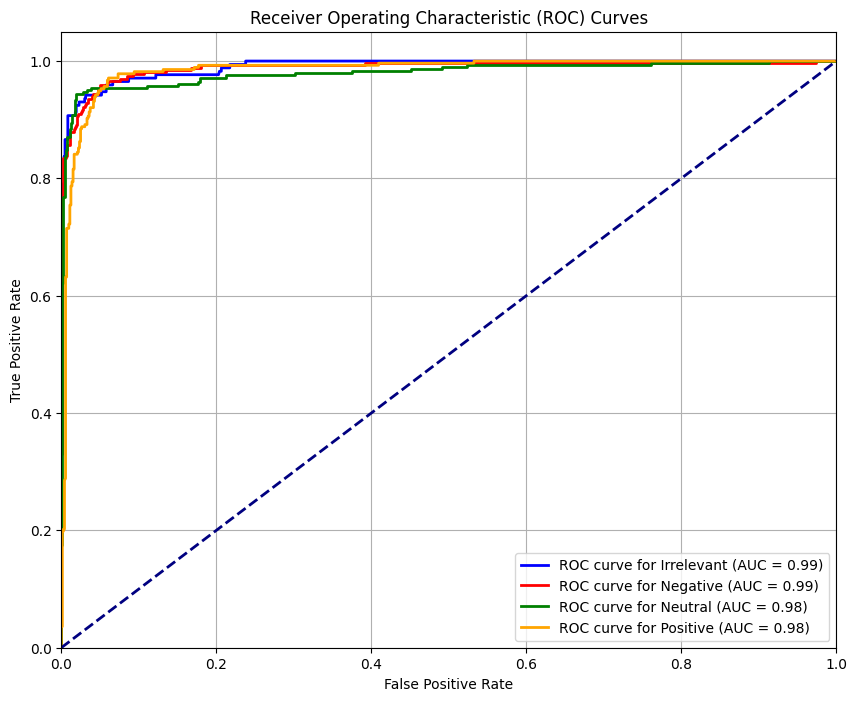


ROC AUC Scores:
Irrelevant: 0.99
Negative: 0.99
Neutral: 0.98
Positive: 0.98


In [28]:
# Binarize the test labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))

# Get decision scores from LinearSVC
y_score = linear_svc_model.decision_function(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']  # Adjust based on number of classes
for i, color in zip(range(len(le.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print ROC AUC scores
print("\nROC AUC Scores:")
for i in range(len(le.classes_)):
    print(f"{le.classes_[i]}: {roc_auc[i]:.2f}")

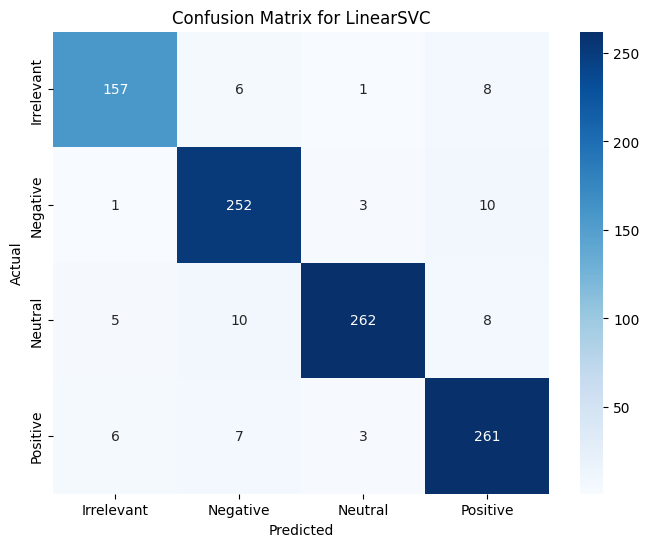

In [29]:
# 7. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_lsvc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for LinearSVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()